In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [2]:
class gmm():
    def __init__(self, dim, no_of_gau, data_points=None, initial_means=None):
        self.dim = dim
        self.no_of_gau = no_of_gau
        
        # Initialize with more stable values
        self.weights = np.ones(self.no_of_gau) / self.no_of_gau
        
        if initial_means is not None:
            self.means = initial_means
            if data_points is not None:
                # Initialize with smaller covariances
                data_std = np.std(data_points, axis=0)
                self.covariances = np.array([np.eye(self.dim) * (data_std * 0.1) for _ in range(self.no_of_gau)])
            else:
                self.covariances = np.array([np.eye(self.dim) * 0.01 for _ in range(self.no_of_gau)])
        elif data_points is not None:
            # Initialize means using data range
            data_mean = np.mean(data_points, axis=0)
            data_std = np.std(data_points, axis=0)
            self.means = np.array([data_mean + (i-1)*2*data_std for i in range(self.no_of_gau)])
            self.covariances = np.array([np.eye(self.dim) * (data_std * 0.1) for _ in range(self.no_of_gau)])
        else:
            self.means = None
            self.covariances = None

    def probability(self, x, mu, cov):
        """Numerically stable probability computation"""
        if x.ndim == 1:
            x = x.reshape(1, -1)
        
        diff = x - mu
        
        # Add small constant to diagonal for numerical stability
        cov_stable = cov + np.eye(self.dim) * 1e-6
        
        try:
            # Use log determinant for numerical stability
            sign, logdet = np.linalg.slogdet(cov_stable)
            inv_sigma = np.linalg.inv(cov_stable)
        except np.linalg.LinAlgError:
            # Fallback if matrix is singular
            cov_stable += np.eye(self.dim) * 1e-3
            sign, logdet = np.linalg.slogdet(cov_stable)
            inv_sigma = np.linalg.inv(cov_stable)
        
        # Compute log probability for numerical stability
        log_norm = -0.5 * (self.dim * np.log(2 * np.pi) + logdet)
        log_exp = -0.5 * np.sum(np.dot(diff, inv_sigma) * diff, axis=1)
        
        # Return exp of log probability, clipped to avoid overflow
        return np.exp(np.clip(log_norm + log_exp, -700, 700))

    def fit_batch(self, data_batch, max_iter=100, tol=1e-6):
        """Fit GMM on a single batch of data"""
        if self.means is None:
            # Initialize parameters using the first batch
            data_mean = np.mean(data_batch, axis=0)
            data_std = np.std(data_batch, axis=0)
            self.means = np.array([data_mean + (i-1)*2*data_std for i in range(self.no_of_gau)])
            self.covariances = np.array([np.eye(self.dim) * data_std for _ in range(self.no_of_gau)])

        n_samples = len(data_batch)
        prev_ll = -np.inf
        
        for iteration in range(max_iter):
            # E-step
            responsibilities = np.zeros((n_samples, self.no_of_gau))
            for k in range(self.no_of_gau):
                responsibilities[:, k] = self.weights[k] * self.probability(data_batch, self.means[k], self.covariances[k])
            
            # Normalize responsibilities
            responsibilities = np.maximum(responsibilities, 1e-300)
            responsibilities /= responsibilities.sum(axis=1, keepdims=True)
            
            # M-step
            Nk = responsibilities.sum(axis=0)
            
            # Check for component collapse
            if np.any(Nk < n_samples * 0.05):  # If any component has less than 5% of points
                return False
            
            self.weights = Nk / n_samples
            
            for k in range(self.no_of_gau):
                if Nk[k] > 0:
                    # Update means
                    self.means[k] = np.sum(responsibilities[:, k:k+1] * data_batch, axis=0) / Nk[k]
                    
                    # Update covariances
                    diff = data_batch - self.means[k]
                    weighted_diff = np.sqrt(responsibilities[:, k:k+1]) * diff
                    self.covariances[k] = np.dot(weighted_diff.T, weighted_diff) / Nk[k]
                    self.covariances[k] += np.eye(self.dim) * 1e-6
            
            # Compute log-likelihood
            log_likelihood = 0
            for k in range(self.no_of_gau):
                log_likelihood += np.sum(np.log(self.weights[k] * self.probability(data_batch, self.means[k], self.covariances[k]) + 1e-300))
            
            if abs(log_likelihood - prev_ll) < tol:
                break
            prev_ll = log_likelihood
            
        return True

    def predict_proba(self, X):
        """Predict probability of each component for given data"""
        probs = np.zeros((len(X), self.no_of_gau))
        for k in range(self.no_of_gau):
            probs[:, k] = self.weights[k] * self.probability(X, self.means[k], self.covariances[k])
        return probs / probs.sum(axis=1, keepdims=True)

    def predict(self, X):
        """Predict cluster labels"""
        return np.argmax(self.predict_proba(X), axis=1)

In [3]:
print("Loading MRI data...")
img = nib.load('./gmm_data/sald_031764_img.nii').get_fdata()
img_shape = img.shape

# Load probability masks
print("Loading probability masks...")
csf_mask = nib.load('./gmm_data/sald_031764_probmask_csf.nii').get_fdata()
gm_mask = nib.load('./gmm_data/sald_031764_probmask_graymatter.nii').get_fdata()
wm_mask = nib.load('./gmm_data/sald_031764_probmask_whitematter.nii').get_fdata()


Loading MRI data...
Loading probability masks...


In [4]:
# Create brain mask to exclude background
brain_mask = (csf_mask + gm_mask + wm_mask) > 0.5

# Apply Gaussian smoothing to reduce noise while preserving edges
print("Preprocessing data...")
smoothed_img = gaussian_filter(img, sigma=0.5)

# Flatten and normalize the image
flat_img = smoothed_img.reshape(-1, 1)
flat_brain_mask = brain_mask.flatten()

# Only use brain voxels for training
brain_voxels = flat_img[flat_brain_mask]
brain_voxels = brain_voxels.reshape(-1, 1)

Preprocessing data...


In [5]:
# Create ground truth labels (only for brain voxels)

true_labels = np.argmax(np.stack([
        csf_mask.flatten()[flat_brain_mask],
        gm_mask.flatten()[flat_brain_mask],
        wm_mask.flatten()[flat_brain_mask]
    ]), axis=0)

In [6]:
brain_voxels_normalized = (brain_voxels - brain_voxels.min()) / (brain_voxels.max() - brain_voxels.min())

In [7]:
# Initialize means based on percentiles of the data
# This ensures means are placed where there is actual data
initial_means = np.array([
    np.percentile(brain_voxels_normalized, 25),  # First quartile for CSF
    np.percentile(brain_voxels_normalized, 50),  # Median for GM
    np.percentile(brain_voxels_normalized, 75)   # Third quartile for WM
]).reshape(-1, 1)

In [8]:
# Keep original data for final evaluation
original_brain_voxels = brain_voxels_normalized.copy()
original_true_labels = true_labels.copy()

In [9]:
print("Training GMM...")
gmm_model = gmm(dim=1, no_of_gau=3, initial_means=initial_means)

# Process in batches
batch_size = 100000
n_samples = len(brain_voxels_normalized)
n_batches = (n_samples + batch_size - 1) // batch_size

best_accuracy = 0
best_model_state = None
patience = 5
no_improvement = 0


for epoch in range(100):
    print(f"Epoch {epoch + 1}/100")
    
    # Shuffle data
    perm = np.random.permutation(n_samples)
    brain_voxels_normalized = brain_voxels_normalized[perm]
    true_labels = true_labels[perm]
    
    for i in tqdm(range(n_batches)):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        batch = brain_voxels_normalized[start_idx:end_idx]
        
        # If fit_batch returns False, component collapse occurred
        if not gmm_model.fit_batch(batch, max_iter=10):
            print("Component collapse detected, stopping training")
            break
    
    # Make predictions on original (unshuffled) data
    brain_predictions = np.zeros(n_samples, dtype=int)
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        batch = original_brain_voxels[start_idx:end_idx]
        brain_predictions[start_idx:end_idx] = gmm_model.predict(batch)
    
    # Calculate accuracy on original data
    current_accuracy = accuracy_score(original_true_labels, brain_predictions)
    print(f"Current accuracy: {current_accuracy:.4f}")
    
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        # Save model state
        best_model_state = {
            'means': gmm_model.means.copy(),
            'covariances': gmm_model.covariances.copy(),
            'weights': gmm_model.weights.copy()
        }
        no_improvement = 0
    else:
        no_improvement += 1
        
    if no_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break

Training GMM...
Epoch 1/100


100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


Current accuracy: 0.7932
Epoch 2/100


100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


Current accuracy: 0.7901
Epoch 3/100


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Current accuracy: 0.7909
Epoch 4/100


100%|██████████| 22/22 [00:03<00:00,  5.86it/s]


Current accuracy: 0.7896
Epoch 5/100


100%|██████████| 22/22 [00:05<00:00,  4.31it/s]


Current accuracy: 0.7876
Epoch 6/100


100%|██████████| 22/22 [00:04<00:00,  4.90it/s]


Current accuracy: 0.7871
Early stopping triggered after 6 epochs


In [10]:
# Restore best model state
gmm_model.means = best_model_state['means']
gmm_model.covariances = best_model_state['covariances']
gmm_model.weights = best_model_state['weights']

In [11]:
# Make final predictions using best model on original data
brain_predictions = np.zeros(n_samples, dtype=int)
for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, n_samples)
    batch = original_brain_voxels[start_idx:end_idx]
    brain_predictions[start_idx:end_idx] = gmm_model.predict(batch)

In [12]:
predictions = np.zeros(len(flat_img), dtype=int)
predictions[flat_brain_mask] = brain_predictions

# Apply spatial smoothing to predictions
smoothed_predictions = np.zeros_like(predictions)
for label in range(3):
    label_mask = (predictions == label).reshape(img_shape)
    smoothed_mask = gaussian_filter(label_mask.astype(float), sigma=0.5) > 0.5
    smoothed_predictions[smoothed_mask.flatten()] = label

Final Segmentation Accuracy: 0.7932

Confusion Matrix:
True\Pred    CSF     GM     WM
CSF       380914  66926      3
GM            15 954998    519
WM             0 371684 347983


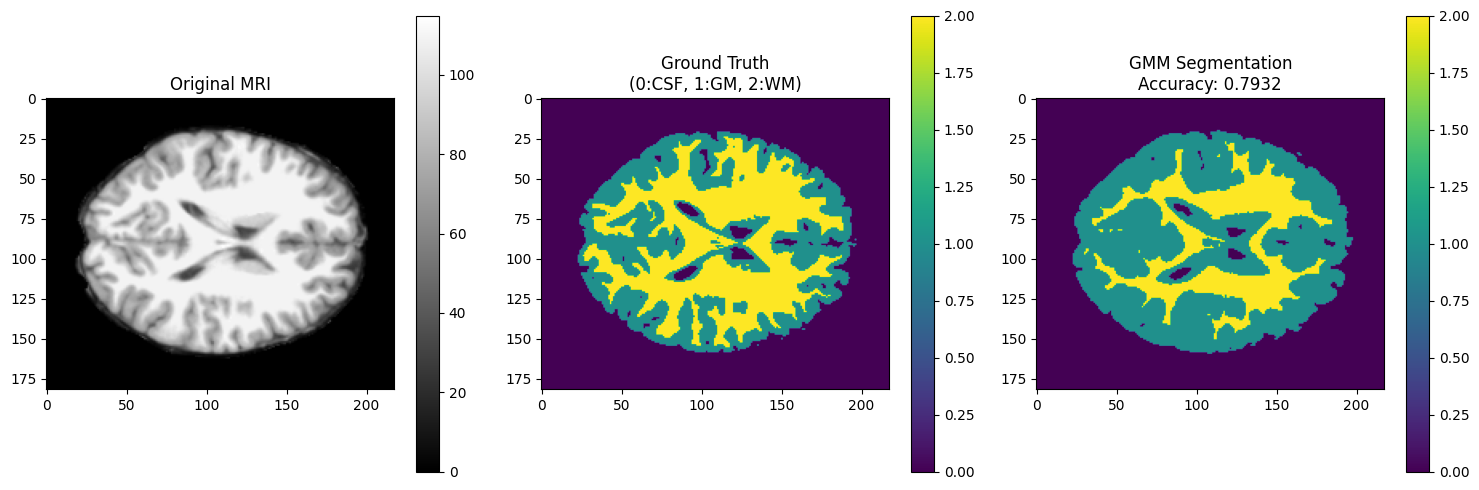

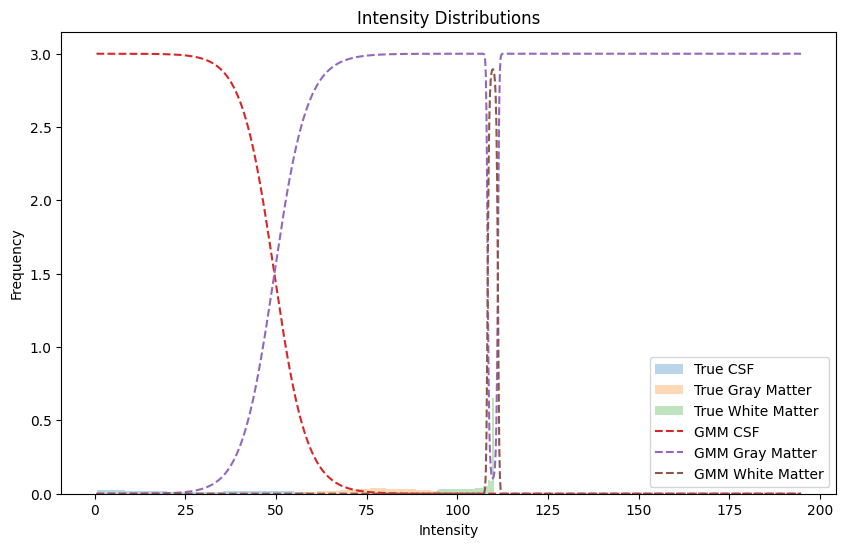

In [14]:
# Calculate final accuracy and confusion matrix
accuracy = accuracy_score(original_true_labels, brain_predictions)
conf_matrix = confusion_matrix(original_true_labels, brain_predictions)
print(f"Final Segmentation Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print("True\\Pred    CSF     GM     WM")
print(f"CSF      {conf_matrix[0,0]:7d} {conf_matrix[0,1]:6d} {conf_matrix[0,2]:6d}")
print(f"GM       {conf_matrix[1,0]:7d} {conf_matrix[1,1]:6d} {conf_matrix[1,2]:6d}")
print(f"WM       {conf_matrix[2,0]:7d} {conf_matrix[2,1]:6d} {conf_matrix[2,2]:6d}")

# Plot results
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(131)
plt.imshow(img[:,:,img_shape[2]//2], cmap='gray')
plt.title('Original MRI')
plt.colorbar()

# Ground truth
plt.subplot(132)
plt.imshow(np.argmax(np.stack([csf_mask, gm_mask, wm_mask]), axis=0)[:,:,img_shape[2]//2])
plt.title('Ground Truth\n(0:CSF, 1:GM, 2:WM)')
plt.colorbar()

# Predictions
plt.subplot(133)
plt.imshow(smoothed_predictions.reshape(img_shape)[:,:,img_shape[2]//2])
plt.title(f'GMM Segmentation\nAccuracy: {accuracy:.4f}')
plt.colorbar()

plt.tight_layout()
plt.show()
plt.savefig('segmentation_results.png')
plt.close()

# Plot intensity distributions
plt.figure(figsize=(10, 6))

# Plot histograms of true labels
for i, (label, name) in enumerate([
    (0, 'CSF'),
    (1, 'Gray Matter'),
    (2, 'White Matter')
]):
    mask = (original_true_labels == i)
    plt.hist(brain_voxels[mask], bins=50, alpha=0.3, 
            density=True, label=f'True {name}')

# Plot GMM distributions
x = np.linspace(brain_voxels.min(), brain_voxels.max(), 1000).reshape(-1, 1)
x_norm = (x - brain_voxels.min()) / (brain_voxels.max() - brain_voxels.min())
probs = gmm_model.predict_proba(x_norm)

for i, name in enumerate(['CSF', 'Gray Matter', 'White Matter']):
    plt.plot(x, probs[:, i] * 3, '--', 
            label=f'GMM {name}')  # Scaled for visibility

plt.title('Intensity Distributions')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()
plt.savefig('intensity_distributions.png')
plt.close()

# Save segmentation as NIFTI with correct dtype
smoothed_predictions = smoothed_predictions.astype(np.uint8)
seg_img = nib.Nifti1Image(smoothed_predictions.reshape(img_shape), affine=np.eye(4), dtype=np.uint8)
nib.save(seg_img, 'gmm_segmentation.nii')
